## Run this notebook

You can launch this notebook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/GHGC_docs/HEAD?labpath=user_data_notebooks/wetland_methane_emissions.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. Collection processed in this notebook is ODIAC CO2 emissions version 2022.
   2. Pass the STAC item into raster API `/stac/tilejson.json` endpoint
   3. We'll visualize two tiles (side-by-side) allowing for comparison of each of the time points using `folium.plugins.DualMap`
   4. After the visualization, we'll perform zonal statistics for a given polygon.
   

## About the Data

The EMIT instrument builds upon NASA’s long history of developing advanced imaging spectrometers for new science and applications. EMIT launched to the International Space Station (ISS) on July 14, 2022. The data shows high-confidence research grade methane plumes from point source emitters - updated as they are identified - in keeping with JPL Open Science and Open Data policy.

# Installing the required libraries.
Please run the next cell to install all the required libraries to run the notebook.

## Querying the STAC API

In [217]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [218]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://dev.ghg.center/api/stac"
RASTER_API_URL = "https://dev.ghg.center/api/raster"

#Please use the collection name similar to the one used in STAC collection.
# Name of the collection for methane plumes emissions. 
collection_name = "nasa-jpl-plumes-emissions-updated"

In [219]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'nasa-jpl-plumes-emissions-updated',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated'}],
 'title': 'CH4 plumes emissions',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-121.71466779194687,
     -38.78784262561637,
     151.09064663683435,
     50.24673720047911]]},
  'temporal': {'interval': [['2022-08-10 00:00:00+00',
     '2023-05-04 00:00:00+00']]}},
 'license': 'CC0-1.0',
 'keywor

Examining the contents of our `collection` under `summaries` we see that the data is available from January 2000 to December 2021. By looking at the `dashboard:time density` we observe that the periodic frequency of these observations is monthly. 

In [220]:
# Check total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=500").json()["features"]
print(f"Found {len(items)} items")

Found 401 items


In [221]:
# Checking if the items are fetched by the request
items[0]

{'id': 'emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504',
 'bbox': [-46.450625050282454,
  -23.700764982003268,
  -46.41212654134425,
  -23.630816986890196],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated/items/emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504'}],
 'assets': {'ch4-plume-emissions': {'href': 's3://ghgc-

This makes sense as there are 22 years between 2000 - 2021, with 12 months per year, meaning 264 records in total.  

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in Methane emissions (CH4) levels using the Raster API

We will explore changes in methane emissions in wetland regions. In this notebook, we'll explore the impacts of these emissions and explore these changes over time. We'll then visualize the outputs on a map using `folium`. 

In [222]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["id"]: item for item in items} 
asset_name = "ch4-plume-emissions"

In [223]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2001 and again for December 2021, so that we can visualize each event independently. 

In [224]:
color_map = "magma"
methane_plume_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[0]]['collection']}&item={items[list(items.keys())[0]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
methane_plume_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-jpl-plumes-emissions-updated&item=emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504&assets=ch4-plume-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=-2927.2822265625%2C5396.69921875'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-46.450625050282454,
  -23.700764982003268,
  -46.41212654134425,
  -23.630816986890196],
 'center': [-46.43137579581335, -23.66579098444673, 0]}

## Visualizing CH4 emissions


In [225]:
# We'll import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for CO2 Layer
map_ = folium.Map(location=(methane_plume_tile["center"][1], methane_plume_tile["center"][0]), zoom_start=13)

# December 2001
map_layer_2001 = TileLayer(
    tiles=methane_plume_tile["tiles"][0],
    attr="GHG",
    opacity=1,
)
map_layer_2001.add_to(map_)

# visualising the map
map_



# Calculating the zonal statistics

## 

In [226]:
# Plume AOI 
methane_plume_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates":[
          [
[
          -46.450625050282454,
          -23.700764982003268
        ],
        [
          -46.41212654134425,
          -23.700764982003268
        ],
        [
          -46.41212654134425,
          -23.630816986890196
        ],
        [
          -46.450625050282454,
          -23.630816986890196
        ],
        [
          -46.450625050282454,
          -23.700764982003268
        ]
        ]],
        "type": "Polygon",
    },
}

In [227]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        -23.630816986890196,
          -46.450625050282454
    ],
    zoom_start=14,
)

folium.GeoJson(texas_dallas_aoi, name="Texas, Dallas").add_to(aoi_map)
aoi_map

In [228]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 401 items


In [229]:
# Explore one item to see what it contains
items[0]

{'id': 'emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504',
 'bbox': [-46.450625050282454,
  -23.700764982003268,
  -46.41212654134425,
  -23.630816986890196],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-jpl-plumes-emissions-updated/items/emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504'}],
 'assets': {'ch4-plume-emissions': {'href': 's3://ghgc-

In [230]:
# the bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "item_id": item["id"],
    }

In [231]:
for item in items:
    print(item["id"])
    break

emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504


With the function above we can generate the statistics for the AOI.

In [232]:
%%time
stats = [generate_stats(item, texas_dallas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'coordinates': [[[-46.450625050282454, -23.700764982003268], [-46.41212654134425, -23.700764982003268], [-46.41212654134425, -23.630816986890196], [-46.450625050282454, -23.630816986890196], [-46.450625050282454, -23.700764982003268]]], 'type': 'Polygon'}, 'properties': {'statistics': {'b1': {'min': -2927.2822265625, 'max': 5396.69921875, 'mean': 720.5838086185045, 'count': 4734.0, 'sum': 3411243.75, 'std': 1031.5550092125752, 'median': 618.9224853515625, 'majority': 123.85083770751953, 'minority': -2268.751708984375, 'unique': 3356.0, 'histogram': [[11.0, 73.0, 466.0, 1352.0, 1465.0, 875.0, 378.0, 87.0, 23.0, 4.0], [-2927.2822265625, -2094.884033203125, -1262.4859619140625, -430.0877990722656, 402.31036376953125, 1234.70849609375, 2067.106689453125, 2899.5048828125, 3731.90283203125, 4564.30126953125, 5396.69921875]], 'valid_percent': 51.69, 'masked_pixels': 4425.0, 'valid_pixels': 4734.0, 'percentile_98': 2970.4060400390626, 'percentile_2': -1216.2584

In [233]:
stats[0]

{'statistics': {'b1': {'min': -2927.2822265625,
   'max': 5396.69921875,
   'mean': 720.5838086185045,
   'count': 4734.0,
   'sum': 3411243.75,
   'std': 1031.5550092125752,
   'median': 618.9224853515625,
   'majority': 123.85083770751953,
   'minority': -2268.751708984375,
   'unique': 3356.0,
   'histogram': [[11.0,
     73.0,
     466.0,
     1352.0,
     1465.0,
     875.0,
     378.0,
     87.0,
     23.0,
     4.0],
    [-2927.2822265625,
     -2094.884033203125,
     -1262.4859619140625,
     -430.0877990722656,
     402.31036376953125,
     1234.70849609375,
     2067.106689453125,
     2899.5048828125,
     3731.90283203125,
     4564.30126953125,
     5396.69921875]],
   'valid_percent': 51.69,
   'masked_pixels': 4425.0,
   'valid_pixels': 4734.0,
   'percentile_98': 2970.4060400390626,
   'percentile_2': -1216.2584741210937}},
 'item_id': 'emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p2_20230504'}

In [234]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    # df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,item_id,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_98,percentile_2
0,emit20230504t135454_o12409_s000_l1b_ch4mf_b010...,-2927.282227,5396.699219,720.583809,4734.0,3411243.75,1031.555009,618.922485,123.850838,-2268.751709,3356.0,"[[11.0, 73.0, 466.0, 1352.0, 1465.0, 875.0, 37...",51.69,4425.0,4734.0,2970.40604,-1216.258474
1,emit20230504t135454_o12409_s000_l1b_ch4mf_b010...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00,9159.0,0.0,NaN,NaN
2,emit20230504t135454_o12409_s000_l1b_ch4mf_b010...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00,9159.0,0.0,NaN,NaN
3,emit20230502t072754_o12205_s001_l1b_ch4mf_b010...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00,9159.0,0.0,NaN,NaN
4,emit20230502t042310_o12203_s001_l1b_ch4mf_b010...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00,9159.0,0.0,NaN,NaN


## Visualizing the Data as a Time Series
We can now explore the ODIAC fossil fuel emission time series available (January 2000 -December 2021) for the Texas, Dallas area of USA. We can plot the data set using the code below:

Text(0.5, 1.0, 'CH4 emission Values for Texas, Dallas (2000-2021)')

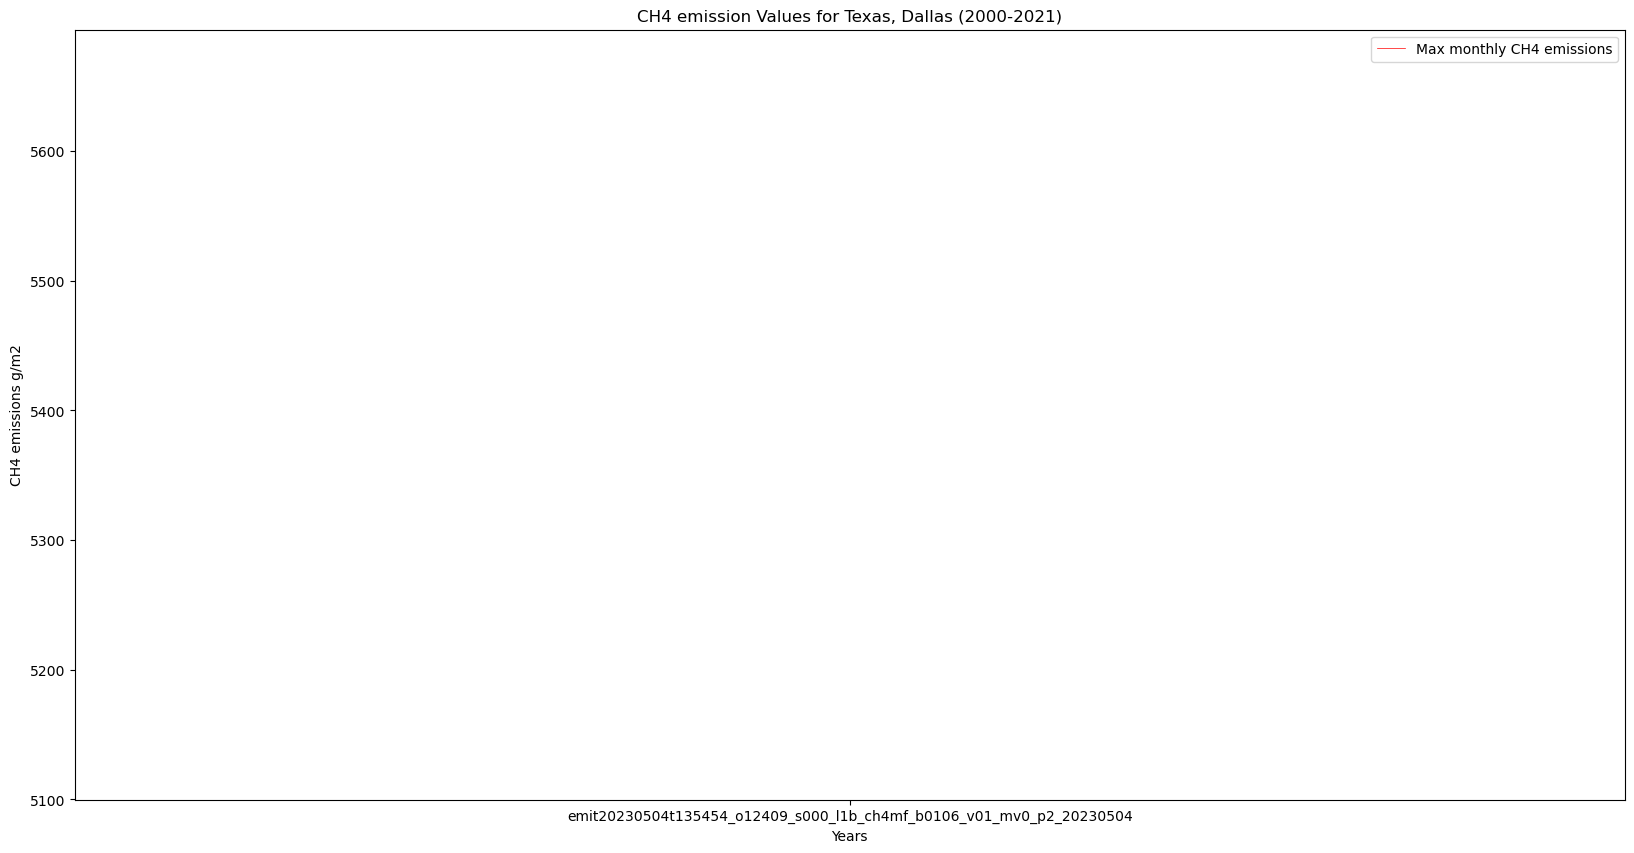

In [235]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["item_id"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CH4 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CH4 emissions g/m2")
plt.title("CH4 emission Values for Texas, Dallas (2000-2021)")

In [236]:
print(items[2]["id"])

emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p0_20230504


In [237]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-jpl-plumes-emissions-updated&item=emit20230504t135454_o12409_s000_l1b_ch4mf_b0106_v01_mv0_p0_20230504&assets=ch4-plume-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=-2927.2822265625%2C5396.69921875'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-46.783013585199605,
  -23.36024295928227,
  -46.76674660959191,
  -23.340180356032786],
 'center': [-46.77488009739576, -23.35021165765753, 0]}

In [238]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        -23.350,
        -46.77,
    ],
    zoom_start=13,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 1
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this case study we have successfully visualized the CH4 emissions from wetland.